P => Piecewise Linear Contrast Stretching

GHE => Global Histogram Equalization

CLAHE => Contrast Limited Adaptive Histogram Equalization

# Function label and jpg and png

In [1]:
import os
import glob
import keras
import sklearn
import cv2 as cv2
import numpy as np
import pandas as pd
import PIL as Image
import seaborn as sns
import pathlib as path
import tensorflow as tf
import matplotlib as mpl
from datetime import datetime
import matplotlib.image as img
from keras import backend as k
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils 
#from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from keras.layers.convolutional import  MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU,Flatten,Activation, GlobalAveragePooling2D, Input
%matplotlib inline

In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['acc']
    temp_vloss = temph['val_acc']
    temp_vacc = temph['val_acc']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index
    # Print the result from the last epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])
    print('--------------------------------------------------')
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['acc'][-1])
    print('Validation accuracy: %s'%history.history['val_acc'][-1])

    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,verbose=True)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    #labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [3]:
from tqdm.notebook import tqdm
import os, fnmatch
from keras import backend as K
from pathlib import Path
# change sub directory in list
def dirToList(dir_path):
  
  #get path create list
  pth = os.listdir(path=dir_path)
  lst_dir = []

  for s in pth:
    temp = str(dir_path + '\\' + s + '\\')
    lst_dir.append(temp)
  
  #remove .csv
  for i in tqdm(range(len(lst_dir))):
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'csv/':
      lst_dir.pop(i-1)
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'md/':
      lst_dir.pop(i-1)

  return lst_dir
# map path to name
def mapName(lab_list, lab_dict):
  temp = []
  for i in tqdm(range(len(lab_list))):
    key_label = lab_dict[lab_list[i]]
    temp.append(key_label)
  return temp

#### label

In [4]:
header_list = ["Type", "Description"]
md = pd.read_csv('C:\\Users\\CPE\\Desktop\\senior2023\\fco metdata.csv', names=header_list)
md

,Type,Description
0,ce,Cemento
1,os,Ossifying
2,fi,Fibrous


In [5]:
label_dict = dict(zip(md['Type'], md['Description']))
label_dict

{'ce': 'Cemento', 'os': 'Ossifying', 'fi': 'Fibrous'}

#### Import model

##### model inceptionresnetv2

In [6]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [7]:
def def_model():
    model = InceptionResNetV2(
    include_top=False, 
    input_shape=(224, 224, 3)
      )
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
  #full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(3, activation='sigmoid')(flat1)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.save('/content/model/InceptionResNetV21.h5')
    model.summary()
    return model

##### model xception

In [8]:
#load pre trained Xception model
model_xcep1 = keras.applications.Xception(weights='imagenet',include_top=True, input_shape=(299,299,3),classifier_activation=None)

In [9]:
for layer in model_xcep1.layers:
    layer.trainable = False
x = Flatten() (model_xcep1.output)
prediction1 = Dense(3, activation = 'softmax')(x)
xcep1_model = Model(inputs = model_xcep1.input, outputs = prediction1)
xcep1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

##### model efficentnetb2

In [10]:
from keras.applications.efficientnet import EfficientNetB2

In [11]:
model_effi = tf.keras.applications.efficientnet.EfficientNetB2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(260,260,3),
    classifier_activation='softmax'
)
for layer in model_effi.layers:
    layer.trainable = False
x = Flatten() (model_effi.output)
prediction1 = Dense(3, activation = 'softmax')(x)
effi1_model = Model(inputs = model_effi.input, outputs = prediction1)
effi1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

# CLAHE

### Train

In [12]:
sub_dir_train_gray = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell')
sub_dir_train_gray

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\ce\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\fi\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\os\\']

In [13]:
sub_dir_train_Path = Path('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell')
all_filepaths_train_gray = list(sub_dir_train_Path.glob(r'**\\*.png'))
all_filepaths_train_gray

[WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_002_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_003_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_004_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_005_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_006_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_007_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_008_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_009_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_010_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_011_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_012_b.png'),
 WindowsPath('C:/Users/CPE/D

In [14]:
all_path = []
all_index = []
for i in tqdm(range(len(sub_dir_train_gray))):
  temp = fnmatch.filter(os.listdir(sub_dir_train_gray[i]), "*.png")
  all_path.append(temp)
all_path_con =[item for sublist in all_path for item in sublist]
for i in tqdm(range(len(all_path_con))):
  index = all_path_con[i][:2]
  all_index.append(index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

In [15]:
all_path_map_train_gray = mapName(all_index, label_dict)
all_path_map_train_gray[:10]

  0%|          | 0/449 [00:00<?, ?it/s]

['Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento']

In [16]:
all_filepaths_df = pd.Series(all_filepaths_train_gray , name = 'filepath').astype(str)
all_path_map_df = pd.Series(all_path_map_train_gray, name = 'label')

all_df = pd.concat([all_filepaths_df, all_path_map_df], axis = 1)
all_df.shape

(449, 2)

In [17]:
all_df.head()

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
1,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
2,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
3,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
4,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento


### Test

In [18]:
sub_dir_test_gray = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell')
sub_dir_test_gray

sub_dir_test_Path = Path('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell')
all_filepaths_test_gray = list(sub_dir_test_Path.glob(r'**\\*.png'))
all_filepaths_test_gray

  0%|          | 0/3 [00:00<?, ?it/s]

[WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_002_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_003_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_004_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_005_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_006_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_007_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_008_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_009_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_010_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_011_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_012_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senio

In [19]:
all_path_test = []
all_index_test = []
for i in tqdm(range(len(sub_dir_test_gray))):
  temp2 = fnmatch.filter(os.listdir(sub_dir_test_gray[i]), "*.png")
  all_path_test.append(temp2)
all_path_test_con =[item for sublist in all_path_test for item in sublist]
for i in tqdm(range(len(all_path_test_con))):
  index = all_path_test_con[i][:2]
  all_index_test.append(index)

all_path_test_map_gray= mapName(all_index_test, label_dict)
all_path_test_map_gray[:10]

all_filepaths_test_df = pd.Series(all_filepaths_test_gray, name = 'filepath').astype(str)
all_path_test_map_df = pd.Series(all_path_test_map_gray, name = 'label')

all_test_df = pd.concat([all_filepaths_test_df, all_path_test_map_df], axis = 1)
all_test_df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

(45, 2)

In [20]:
all_test_df

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
1,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
2,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
3,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
4,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
5,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
6,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
7,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
8,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
9,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento


### Validation

In [21]:
ce_train_data = all_df.loc[all_df['label'] == label_dict['ce']]
fi_train_data = all_df.loc[all_df['label'] == label_dict['fi']]
os_train_data = all_df.loc[all_df['label'] == label_dict['os']]

ce_tr, ce_va = train_test_split(ce_train_data, test_size = .05)
fi_tr, fe_va = train_test_split(fi_train_data, test_size = .45)
os_tr, os_va = train_test_split(os_train_data, test_size = .75)

In [22]:
df_train = pd.concat([ce_tr,fi_tr,os_tr])
print(df_train.shape)
df_train.head()

(198, 2)


,filepath,label
45,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
53,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
11,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
43,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
67,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento


In [23]:
df_val = pd.concat([ce_va,fe_va,os_va])
print(df_val.shape)
df_val.sample(10)

(251, 2)


,filepath,label
424,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
152,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Fibrous
144,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Fibrous
130,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Fibrous
361,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
386,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
446,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
327,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
345,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
404,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying


### Generator

In [24]:
IMAGE_SIZE = [224,224]
train_generator = ImageDataGenerator(
    rescale=1./255, #rescal Grayscale
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
validation_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)

X_COL = 'filepath'
Y_COL = 'label'

training_set_gray = train_generator.flow_from_dataframe(
    dataframe = df_train,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



validation_set_gray = validation_generator.flow_from_dataframe(
    dataframe = df_val,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



test_set_gray = test_generator.flow_from_dataframe(
    dataframe = all_test_df,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')

Found 198 validated image filenames belonging to 3 classes.
Found 251 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


### Model InceptionResNetV 2

In [38]:
incepv2_1 = def_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_207 (Batch  (None, 111, 111, 32  96         ['conv2d_207[0][0]']             
 Normalization)                 )                                                           

In [41]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_inceptionresnetv2_gray_remake_model.h5', save_best_only=True, monitor='val_loss')

history_inceptionresnetv2_gray_remake_model = incepv2_1.fit(
                      training_set_gray,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_gray),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
50/50 [==============================] - 39s 780ms/step - loss: 0.6642 - acc: 0.9646 - val_loss: 3.5481 - val_acc: 0.8486
Epoch 2/100
50/50 [==============================] - 39s 794ms/step - loss: 0.8828 - acc: 0.9394 - val_loss: 2.2379 - val_acc: 0.8685
Epoch 3/100
50/50 [==============================] - 40s 799ms/step - loss: 1.2094 - acc: 0.9444 - val_loss: 3.5894 - val_acc: 0.8526
Epoch 4/100
50/50 [==============================] - 38s 771ms/step - loss: 1.4935 - acc: 0.9091 - val_loss: 13.6387 - val_acc: 0.6614
Epoch 5/100
50/50 [==============================] - 39s 784ms/step - loss: 1.1440 - acc: 0.9343 - val_loss: 3.8807 - val_acc: 0.8606
Epoch 6/100
50/50 [==============================] - 42s 858ms/step - loss: 1.0165 - acc: 0.9293 - val_loss: 3.4751 - val_acc: 0.8765
Epoch 7/100
50/50 [==============================] - 43s 866ms/step - loss: 1.2207 - acc: 0.9293 - val_loss: 2.8191 - val_acc: 0.9004
Epoch 8/100
50/50 [==============================] - 45s 903m

Highest validation accuracy in Epoch: 38
Train accuracy: 0.9444444179534912
Validation accuracy: 0.9601593613624573
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9797979593276978
Validation accuracy: 0.9362549781799316


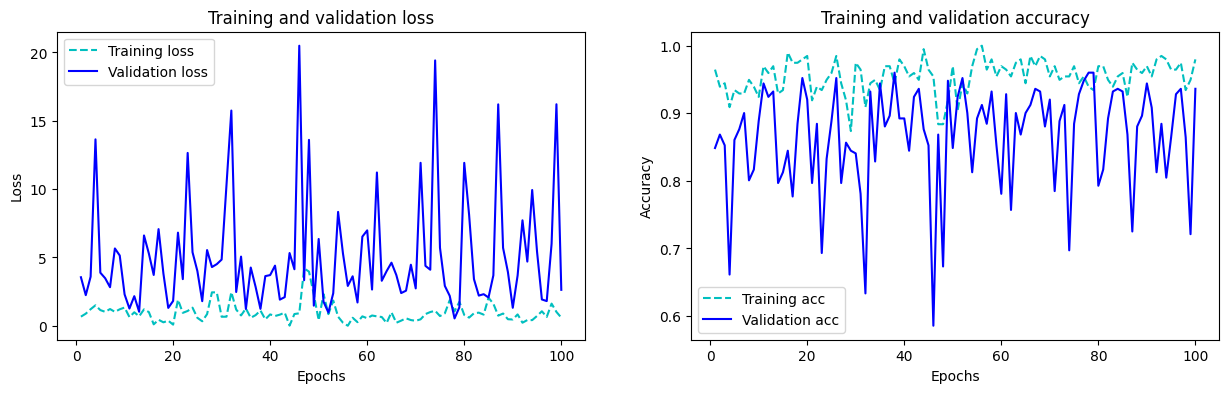

In [42]:
show_result(history_inceptionresnetv2_gray_remake_model)

In [43]:
inrn2_model_remake = models.load_model('history_inceptionresnetv2_gray_remake_model.h5')
#all_test_df_clahe["label"] = all_test_df_clahe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(inrn2_model_clahe, test_set_clahe, all_test_df_clahe['label'])

In [45]:
result_remake = inrn2_model_remake.evaluate(test_set_gray, verbose=0)

print("Test loss: {:.5f}".format(result_remake[0]))
print("Test accuracy: {:.2f}".format(result_remake[1]))

Test loss: 2.90607
Test accuracy: 0.82


### Grad CAM

### Model Xception

In [ ]:
xcep_3 = xcep1_model

In [ ]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_Xception_gray_remake_model.h5', save_best_only=True, monitor='val_loss')

history_Xception_gray_remake_model = xcep_3.fit(
                      training_set_gray,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_gray),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
50/50 [==============================] - 33s 622ms/step - loss: 1.1526 - acc: 0.5051 - val_loss: 0.8296 - val_acc: 0.6574
Epoch 2/100
50/50 [==============================] - 34s 691ms/step - loss: 0.6983 - acc: 0.7121 - val_loss: 0.3846 - val_acc: 0.8606
Epoch 3/100
50/50 [==============================] - 34s 696ms/step - loss: 0.4635 - acc: 0.8131 - val_loss: 0.5468 - val_acc: 0.8088
Epoch 4/100
50/50 [==============================] - 33s 666ms/step - loss: 0.4580 - acc: 0.8081 - val_loss: 0.8178 - val_acc: 0.7211
Epoch 5/100
50/50 [==============================] - 33s 669ms/step - loss: 0.3336 - acc: 0.9040 - val_loss: 0.4932 - val_acc: 0.8367
Epoch 6/100
50/50 [==============================] - 33s 665ms/step - loss: 0.3625 - acc: 0.8838 - val_loss: 0.4861 - val_acc: 0.7888
Epoch 7/100
50/50 [==============================] - 35s 703ms/step - loss: 0.3530 - acc: 0.8788 - val_loss: 0.6661 - val_acc: 0.7729
Epoch 8/100
50/50 [==============================] - 38s 758ms

Highest validation accuracy in Epoch: 81
Train accuracy: 0.9040403962135315
Validation accuracy: 0.9282868504524231
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9090909361839294
Validation accuracy: 0.8804780840873718


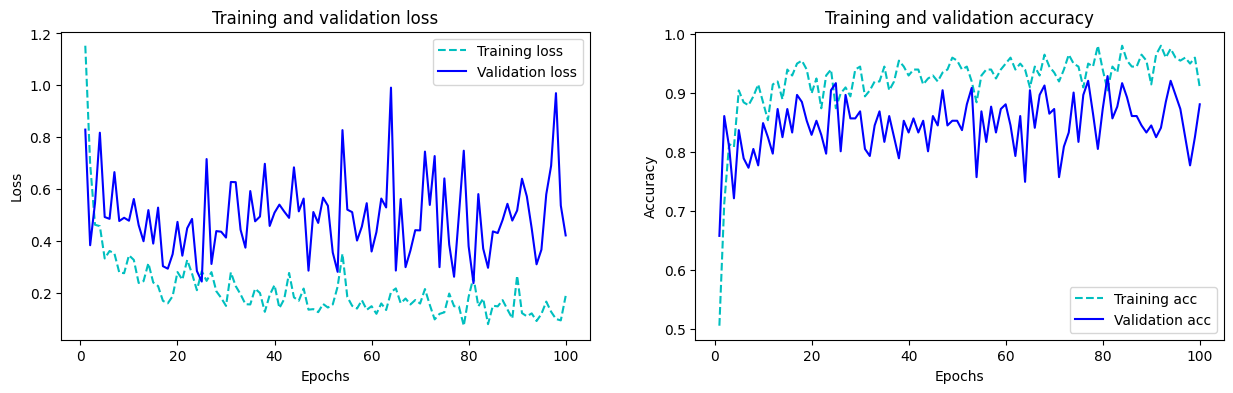

In [ ]:
show_result(history_Xception_gray_remake_model)

In [ ]:
xcep_model_remake = models.load_model('history_Xception_gray_remake_model.h5')
#all_test_df_clahe["label"] = all_test_df_clahe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(xcep_model_clahe, test_set_clahe, all_test_df_clahe['label'])

In [ ]:
result_remake2 = xcep_model_remake.evaluate(test_set_gray, verbose=0)

print("Test loss: {:.5f}".format(result_remake2[0]))
print("Test accuracy: {:.2f}".format(result_remake2[1]))

Test loss: 0.41326
Test accuracy: 0.91


### Model efficientnetB 2

In [62]:
model_effi = tf.keras.applications.efficientnet.EfficientNetB2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(260,260,3),
    classifier_activation='softmax'
)
for layer in model_effi.layers:
    layer.trainable = False
x = Flatten() (model_effi.output)
prediction1 = Dense(3, activation = 'softmax')(x)
effi1_model = Model(inputs = model_effi.input, outputs = prediction1)
effi1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

In [ ]:
effi_3 = effi1_model

In [33]:
#mcp_save = ModelCheckpoint('history_efficientnet1_1_model_clahe.h5', save_best_only=True, monitor='val_loss')
history_efficientnetB2_gray_remake_model = effi_3.fit(
                      training_set_gray,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_gray)
                      #callbacks=[mcp_save]
                      )

Epoch 1/100
50/50 [==============================] - 32s 525ms/step - loss: 1.0993 - acc: 0.3283 - val_loss: 1.1106 - val_acc: 0.2191
Epoch 2/100
50/50 [==============================] - 24s 493ms/step - loss: 1.0988 - acc: 0.3131 - val_loss: 1.1088 - val_acc: 0.0159
Epoch 3/100
50/50 [==============================] - 25s 500ms/step - loss: 1.0987 - acc: 0.3131 - val_loss: 1.1114 - val_acc: 0.0159
Epoch 4/100
50/50 [==============================] - 24s 489ms/step - loss: 1.0985 - acc: 0.3434 - val_loss: 1.1137 - val_acc: 0.0159
Epoch 5/100
50/50 [==============================] - 24s 492ms/step - loss: 1.0984 - acc: 0.3485 - val_loss: 1.1130 - val_acc: 0.0159
Epoch 6/100
50/50 [==============================] - 24s 490ms/step - loss: 1.0984 - acc: 0.3485 - val_loss: 1.1134 - val_acc: 0.0159
Epoch 7/100
50/50 [==============================] - 24s 485ms/step - loss: 1.0983 - acc: 0.3485 - val_loss: 1.1145 - val_acc: 0.0159
Epoch 8/100
50/50 [==============================] - 24s 489ms

In [1]:
#effi_3.save('effi_gray.h5')

Highest validation accuracy in Epoch: 1
Train accuracy: 0.32828283309936523
Validation accuracy: 0.21912351250648499
--------------------------------------------------
Last train Epoch
Train accuracy: 0.3484848439693451
Validation accuracy: 0.01593625545501709


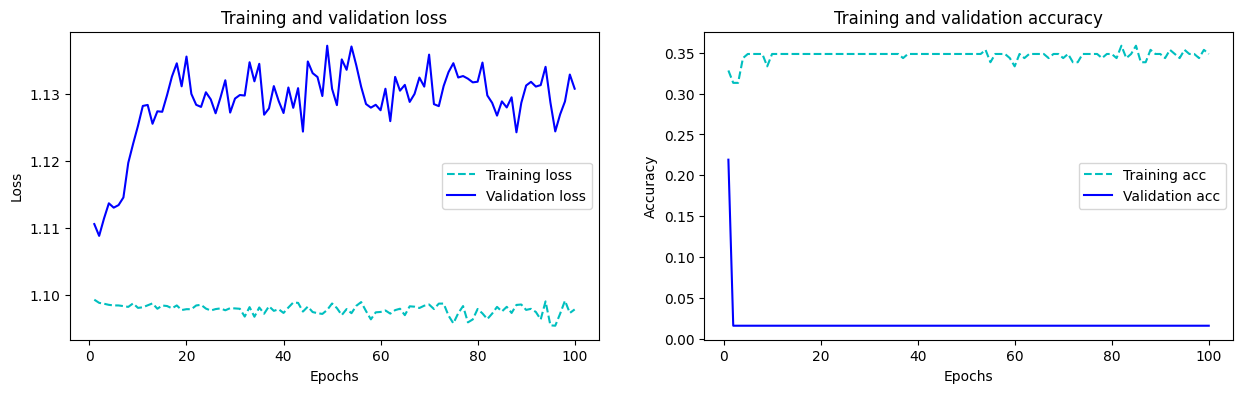

In [34]:
show_result(history_efficientnetB2_gray_remake_model)

In [35]:
result_gray3 = history_efficientnetB2_gray_remake_model.evaluate(test_set_gray, verbose=0)

print("Test loss: {:.5f}".format(result_gray3[0]))
print("Test accuracy: {:.2f}".format(result_gray3[1]))

In [2]:
#effi_model_gray = models.load_model('history_efficientnetB2_gray_remake_model.h5')
#all_test_df_clahe["label"] = all_test_df_clahe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(effi_model_clahe, test_set_clahe, all_test_df_clahe['label'])

In [37]:
#predict_ef('C:\\Users\\CPE\\Desktop\\senior2023\\ossifying_fibroma.jpg',effi_model_clahe)